In [1]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/home/ra/Codes/multilang_timescale


In [2]:
import pickle
import json

import time
import logging

import warnings

import joblib

import numpy as np
import pandas as pd

from scipy.stats import zscore

# from himalaya.ridge import RidgeCV, Ridge

from himalaya.backend import set_backend
from himalaya.kernel_ridge import (
    Kernelizer,
    ColumnKernelizer,
    MultipleKernelRidgeCV,
    WeightedKernelRidge,
)
from himalaya.scoring import r2_score_split, correlation_score_split


from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from voxelwise_tutorials.delayer import Delayer
from voxelwise_tutorials.utils import explainable_variance
from voxelwise_tutorials.viz import (
    plot_2d_flatmap_from_mapper,
    plot_flatmap_from_mapper,
)

import matplotlib.pyplot as plt

In [3]:

from src.utils import make_delayed, load_dict
from src.config import train_stories, test_stories, timescales
from src.settings import TrainerConfig, SubjectConfig, FeatureConfig
from src.trainer import Trainer

# Config

In [4]:
config_dir = ".temp/config/"
config_subject_dir = ".temp/config/subject/"
config_train_dir = ".temp/config/train/"
config_feature_dir = ".temp/config/feature"

if not os.path.exists(config_subject_dir):
    os.makedirs(config_dir)

if not os.path.exists(config_train_dir):
    os.makedirs(config_train_dir)

if not os.path.exists(config_feature_dir):
    os.makedirs(config_feature_dir)

In [5]:
lm_feature_type = "BERT"
subject_id = "07"

In [6]:
sub_config = SubjectConfig()

sub_config.sub_id = subject_id 

sub_config.sub_fmri_train_path = (
    f"/media/data/dataset/timescale/fmri/deniz2019/subject{subject_id}_reading_fmri_data_trn.hdf"
)
sub_config.sub_fmri_test_path = (
    f"/media/data/dataset/timescale/fmri/deniz2019/subject{subject_id}_reading_fmri_data_val.hdf"
)
sub_config.sub_fmri_mapper_path = (
    f"/media/data/dataset/timescale/fmri/deniz2019/subject{subject_id}_mappers.hdf"
)
sub_config.task = "reading"

In [7]:
# save to json
with open(
    config_subject_dir + f"subject-{sub_config.sub_id}-{sub_config.task}.json", "w"
) as fp:
    json.dump(sub_config.__dict__, fp, indent=4)

In [8]:
def generate_feature_config(lm_feature_type=lm_feature_type):
    timescales = [
        "2_4_words",
        "4_8_words",
        "8_16_words",
        "16_32_words",
        "32_64_words",
        "64_128_words",
        "128_256_words",
        "256+ words",
    ]

    if lm_feature_type == "BERT":
        lm_feature_path = (
            "/media/data/dataset/timescale/features/en/timescales_BERT_all.npz"
        )
    else:
        lm_feature_path = (
            "/media/data/dataset/timescale/features/en/timescales_mBERT_all.npz"
        )

    dir = os.path.join(config_train_dir, lm_feature_type.lower())
    if not os.path.exists(dir):
        os.makedirs(dir)

    f_dir = os.path.join(config_feature_dir, lm_feature_type.lower())
    if not os.path.exists(f_dir):
        os.makedirs(f_dir)

    for t in timescales:
        # Feature Config
        feature_config = FeatureConfig()

        feature_config.timescale = t

        feature_config.lm_feature_path = lm_feature_path

        feature_config.sensory_feature_train_paths = (
            "/media/data/dataset/timescale/features/en/features_trn_NEW.hdf"
        )
        feature_config.sensory_feature_test_paths = (
            "/media/data/dataset/timescale/features/en/features_val_NEW.hdf"
        )
        feature_config.sensory_features = ["numletters", "numwords"]

        feature_config.motion_energy_feature_paths = (
            "/media/data/dataset/timescale/features/en/m_ll.npz"
        )
        feature_config.motion_energy_features = ["7"]

        ## saving config
        fn = os.path.join(f_dir, t + "-feature_config.json")
        with open(fn, "w") as fp:
            json.dump(feature_config.__dict__, fp, indent=4)

In [9]:
generate_feature_config(lm_feature_type="BERT")
generate_feature_config(lm_feature_type="mBERT")

In [10]:
def generate_trainer_config(lm_feature_type:str):
    # Trainer Config
    trainer_config = TrainerConfig()

    trainer_config.backend = "torch_cuda"


    trainer_config.hyperparams_save_dir = (
        f".temp/results/{lm_feature_type.lower()}/hyperparams"
    )

    trainer_config.stats_save_dir = f".temp/results/{lm_feature_type.lower()}/stats"
    ## saving config
    fn = os.path.join(config_train_dir, f"{lm_feature_type.lower()}_trainer_config.json")
    with open(fn, "w") as fp:
        json.dump(trainer_config.__dict__, fp, indent=4)

In [11]:
generate_trainer_config(lm_feature_type="BERT")
generate_trainer_config(lm_feature_type="mBERT")

In [12]:
# Trainer Config
trainer_config = TrainerConfig()

trainer_config.backend = "torch_cuda"


trainer_config.hyperparams_save_dir = (
    f".temp/results/{lm_feature_type.lower()}/hyperparams"
)

trainer_config.stats_save_dir = f".temp/results/{lm_feature_type.lower()}/stats"
## saving config
fn = os.path.join(config_train_dir, "trainer_config.json")
with open(fn, "w") as fp:
    json.dump(trainer_config.__dict__, fp, indent=4)

# Trainer

In [11]:
# class Trainer:
#     def __init__(self, sub_config: SubjectConfig, feature_config: FeatureConfig):
#         self.sub_config = sub_config
#         self.feature_config = feature_config

#         self.prepare_data()
#         self.prepare_features()

#     def prepare_data(self):
#         train_data = load_dict(self.sub_config.sub_fmri_train_path)
#         test_data = load_dict(self.sub_config.sub_fmri_test_path)

#         # zscore data
#         ## zscore data
#         train_data = np.vstack(
#             [
#                 zscore(
#                     train_data[story][
#                         self.sub_config.sub_trim_start : -self.sub_config.sub_trim_end,
#                         :,
#                     ],
#                     axis=0,
#                 )
#                 for story in list(train_data.keys())
#             ]
#         )
#         self.train_data = np.nan_to_num(train_data)

#         # computing ev before masking
#         ev = explainable_variance(test_data["story_11"])
#         self.mask = ev > 0.1

#         test_data = zscore(
#             np.mean(test_data["story_11"], axis=0)[
#                 self.sub_config.sub_trim_start : -self.sub_config.sub_trim_end, :
#             ],
#             axis=0,
#         )
#         self.test_data = np.nan_to_num(test_data)

#     def prepare_features(self):
#         train_features = []
#         test_features = []

#         # lm-derived feature
#         ## train
#         lm_feature_train_test = np.load(
#             self.feature_config.lm_feature_path, allow_pickle=True
#         )
#         lm_features = lm_feature_train_test["train"].tolist()[
#             self.feature_config.timescale
#         ]
#         train_features.append(
#             {
#                 "name": "lm",
#                 "size": lm_features.shape[1],
#                 "feature": np.nan_to_num(lm_features),
#             }
#         )
#         ### test
#         lm_features = lm_feature_train_test["test"].tolist()[
#             self.feature_config.timescale
#         ]
#         test_features.append(
#             {
#                 "name": "lm",
#                 "size": lm_features.shape[1],
#                 "feature": np.nan_to_num(lm_features),
#             }
#         )

#         # sensory-level features
#         ## train
#         if self.feature_config.sensory_feature_train_paths is not None:
#             sensory_level_train_feature = load_dict(
#                 self.feature_config.sensory_feature_train_paths
#             )

#             for feature in self.feature_config.sensory_features:
#                 story_stacked = []
#                 for story in list(sensory_level_train_feature.keys()):
#                     story_stacked.append(
#                         sensory_level_train_feature[story][feature][
#                             self.feature_config.sensory_feature_trim_start : -self.feature_config.sensory_feature_trim_end
#                         ]
#                     )
#                 story_stacked = np.vstack(story_stacked)
#                 train_features.append(
#                     {
#                         "name": feature,
#                         "size": story_stacked.shape[1],
#                         "feature": np.nan_to_num(story_stacked),
#                     }
#                 )
#         ## test
#         if self.feature_config.sensory_feature_test_paths is not None:
#             sensory_level_test_feature = load_dict(
#                 self.feature_config.sensory_feature_test_paths
#             )

#             for feature in self.feature_config.sensory_features:
#                 story_stacked = []
#                 for story in list(sensory_level_test_feature.keys()):
#                     story_stacked.append(
#                         sensory_level_test_feature[story][feature][
#                             self.feature_config.sensory_feature_trim_start : -self.feature_config.sensory_feature_trim_end
#                         ]
#                     )
#                 story_stacked = np.vstack(story_stacked)
#                 test_features.append(
#                     {
#                         "name": feature,
#                         "size": story_stacked.shape[1],
#                         "feature": np.nan_to_num(story_stacked),
#                     }
#                 )

#         # motion-energy features
#         if self.feature_config.motion_energy_feature_paths is not None:
#             moten = np.load(
#                 self.feature_config.motion_energy_feature_paths, allow_pickle=True
#             )
#             ## train
#             moten_train = moten["train"].tolist()

#             for f in self.feature_config.motion_energy_features:
#                 train_features.append(
#                     {
#                         "name": f"motion energy : {f}",
#                         "size": moten_train[f].shape[1],
#                         "feature": np.nan_to_num(moten_train[f]),
#                     }
#                 )

#             ## test
#             moten_test = moten["test"].tolist()

#             for f in self.feature_config.motion_energy_features:
#                 test_features.append(
#                     {
#                         "name": f"motion energy : {f}",
#                         "size": moten_test[f].shape[1],
#                         "feature": np.nan_to_num(moten_test[f]),
#                     }
#                 )

#         # join features
#         self.train_feature = np.hstack([f["feature"] for f in train_features])
#         self.test_feature = np.hstack([f["feature"] for f in test_features])

#         # delays = np.arange(1, trainer_config.feature_delay + 1)
#         # self.train_feature = make_delayed(train_feature, delays)

#         assert (
#             self.train_feature.shape[0] == self.train_data.shape[0]
#         ), "Feature and data shape mismatch"

#         assert (
#             self.test_feature.shape[0] == self.test_data.shape[0]
#         ), "Feature and data shape mismatch"

#         # remove 'feature' key, save memory
#         for f in train_features:
#             del f["feature"]

#         for f in test_features:
#             del f["feature"]

#         self.train_feature_info = train_features
#         self.test_feature_info = test_features

#     def get_kernelizer(self):
#         preprocess_pipeline = make_pipeline(
#             StandardScaler(with_mean=True, with_std=False),
#             Delayer(delays=[1, 2, 3, 4]),
#             Kernelizer(kernel="linear"),
#         )

#         n_feature_list = [f["size"] for f in self.train_feature_info]
#         start_and_end = np.concatenate([[0], np.cumsum(n_feature_list)])
#         slices = [
#             slice(start, end)
#             for start, end in zip(start_and_end[:-1], start_and_end[1:])
#         ]

#         kernelizers_tuples = [
#             (name, preprocess_pipeline, slice_)
#             for name, slice_ in zip(
#                 [f["name"] for f in self.train_feature_info],
#                 slices,
#             )
#         ]
#         return ColumnKernelizer(kernelizers_tuples)

#     def prepare_training_pipeline(self, trainer_config: TrainerConfig):
#         # preprocess
#         columnn_kernelizer = self.get_kernelizer()
#         # model
#         solver_params = dict(
#             n_iter=trainer_config.n_iter,
#             alphas=np.logspace(
#                 trainer_config.alpha_min,
#                 trainer_config.alpha_max,
#                 trainer_config.alpha_num,
#             ),
#             n_targets_batch=trainer_config.n_targets_batch,
#             n_alphas_batch=trainer_config.n_alphas_batch,
#             n_targets_batch_refit=trainer_config.n_targets_batch_refit,
#         )

#         mkr_model = MultipleKernelRidgeCV(
#             kernels="precomputed",
#             solver=trainer_config.solver,
#             solver_params=solver_params,
#             cv=trainer_config.kfolds,
#         )

#         return make_pipeline(columnn_kernelizer, mkr_model)

#     # def load_kernelizer(self, trainer_config: TrainerConfig):
#     #     kernelizer_fn = os.path.join(
#     #         trainer_config.model_save_path,
#     #         f"kernelizer-{self.sub_config.sub_id}-{self.sub_config.task}-{trainer_config.timescale}.joblib",
#     #     )

#     #     with open(kernelizer_fn, "rb") as f:
#     #         columnn_kernelizer = joblib.load(f)

#     #     return columnn_kernelizer

#     #     # # fit ColumnKernelizer on training data
#     #     # train_feature = self.train_feature.astype("float32")
#     #     # train_data = self.train_data.astype("float32")

#     #     # if trainer_config.fit_on_mask:
#     #     #     train_data = train_data[:, self.mask]
#     #     #     # print("using mask size of {train_data.shape}")

#     #     # pipeline[0].fit(train_feature, train_data)

#     def train(self, trainer_config: TrainerConfig, force_cpu: bool = False):
#         if force_cpu:   
#             set_backend("numpy", on_error="warn")
#         else:
#             set_backend(trainer_config.backend, on_error="warn")

#         pipeline = self.prepare_training_pipeline(trainer_config)

#         # prepare features
#         # Set backend

#         # casting
#         train_feature = self.train_feature.astype("float32")
#         train_data = self.train_data.astype("float32")

#         if trainer_config.fit_on_mask:
#             train_data = train_data[:, self.mask]
#             # print("using mask size of {train_data.shape}")

#         # Fitting
#         print("Fitting model...")
#         start = time.time()

#         pipeline.fit(train_feature, train_data)

#         print(f"training took {time.time() - start} seconds")

#         # save model
#         # if not os.path.exists(trainer_config.weights_save_path):
#         #     os.makedirs(trainer_config.weights_save_path)
#         if not os.path.exists(trainer_config.hyperparams_save_dir):
#             os.makedirs(trainer_config.hyperparams_save_dir)
#         # if not os.path.exists(trainer_config.model_save_path):
#         #     os.makedirs(trainer_config.model_save_path)

#         # saving model
#         # weight_fn = os.path.join(
#         #     trainer_config.weights_save_path,
#         #     f"{self.sub_config.sub_id}-{self.sub_config.task}-{trainer_config.timescale}.npz",
#         # )

#         hyperparams_fn = os.path.join(
#             trainer_config.hyperparams_save_dir,
#             f"{self.sub_config.sub_id}-{self.sub_config.task}-{self.feature_config.timescale}.npz",
#         )

#         # kernelizer_fn = os.path.join(
#         #     trainer_config.model_save_path,
#         #     f"kernelizer-{self.sub_config.sub_id}-{self.sub_config.task}-{trainer_config.timescale}.joblib")

#         # save hyperparams
#         deltas = pipeline[-1].deltas_.cpu().numpy()
#         best_alphas = pipeline[-1].best_alphas_.cpu().numpy()

#         np.savez_compressed(hyperparams_fn, deltas=deltas, best_alphas=best_alphas)

#         # ## save weights
#         # weights = self.backend.to_numpy(pipeline[-1].dual_coef_)
#         # np.savez_compressed(weight_fn, weights=weights)

#         # ## save alphas
#         # alphas = self.backend.to_numpy(pipeline[-1].best_alphas_)
#         # np.savez_compressed(alpha_fn, alphas=alphas)

#         # with open(kernelizer_fn, "wb") as f:
#         #     joblib.dump(pipeline[0], f, compress=True)

#     def refit_and_evaluate(self, trainer_config: TrainerConfig, force_cpu: bool = True):
#         if force_cpu:
#             backend = set_backend("numpy", on_error="warn")
#         else:
#             backend = set_backend(trainer_config.backend, on_error="warn")

#         # load hyperparams
#         hyperparams_fn = os.path.join(
#             trainer_config.hyperparams_save_dir,
#             f"{self.sub_config.sub_id}-{self.sub_config.task}-{self.feature_config.timescale}.npz",
#         )

#         hyperparams = np.load(hyperparams_fn)
#         deltas = hyperparams["deltas"].astype("float32") if trainer_config.use_fitted_deltas else "zeros"
#         best_alphas = hyperparams["best_alphas"].astype("float32") if trainer_config.use_fitted_alphas else 1

#         # load kernelizer
#         columnn_kernelizer = self.get_kernelizer()

#         model = WeightedKernelRidge(
#             alpha=best_alphas, deltas=deltas, kernels="precomputed",
#         )

#         pipeline = make_pipeline(columnn_kernelizer, model)

#         # casting
#         train_feature = self.train_feature.astype("float32")
#         train_data = self.train_data.astype("float32")

#         test_feature = self.test_feature.astype("float32")
#         test_data = self.test_data.astype("float32")

#         if trainer_config.fit_on_mask:
#             train_data = train_data[:, self.mask]
#             test_data = test_data[:, self.mask]
#             # print("using mask size of {train_data.shape}")

#         # prepare features
#         pipeline.fit(train_feature, train_data)

#         # score on train
#         train_pred_split = pipeline.predict(train_feature, split=True)
#         train_r2_score_mask = r2_score_split(train_data, train_pred_split)
#         train_r_score_mask = correlation_score_split(train_data, train_pred_split)

#         # score on test
#         test_pred_split = pipeline.predict(test_feature, split=True)
#         test_r2_score_mask = r2_score_split(test_data, test_pred_split)
#         test_r_score_mask = correlation_score_split(test_data, test_pred_split)

#         if trainer_config.fit_on_mask:
#             n_kernels = train_r2_score_mask.shape[0]
#             n_voxels = self.test_data.shape[1]

#             train_r2_split_scores = np.zeros((n_kernels, n_voxels))
#             train_r_split_scores = np.zeros((n_kernels, n_voxels))

#             test_r2_split_scores = np.zeros((n_kernels, n_voxels))
#             test_r_split_scores = np.zeros((n_kernels, n_voxels))

#             train_r2_split_scores[:, self.mask] = backend.to_numpy(train_r2_score_mask)
#             train_r_split_scores[:, self.mask] = backend.to_numpy(train_r_score_mask)

#             test_r2_split_scores[:, self.mask] = backend.to_numpy(test_r2_score_mask)
#             test_r_split_scores[:, self.mask] = backend.to_numpy(test_r_score_mask)
#         else:
#             train_r2_split_scores = train_r2_score_mask
#             train_r_split_scores = train_r_score_mask
#             test_r2_split_scores = test_r2_score_mask
#             test_r_split_scores = test_r_score_mask

#         # saving stat
#         if not os.path.exists(trainer_config.stats_save_dir):
#             os.makedirs(trainer_config.stats_save_dir)

#         stat_fn = os.path.join(
#             trainer_config.stats_save_dir,
#             f"{self.sub_config.sub_id}-{self.sub_config.task}-{self.feature_config.timescale}.npz",
#         )

#         np.savez_compressed(
#             stat_fn,
#             train_r2_split_scores=train_r2_split_scores,
#             train_r_split_scores=train_r_split_scores,
#             test_r2_split_scores=test_r2_split_scores,
#             test_r_split_scores=test_r_split_scores,
#         )

#     # def load_model(self, trainer_config: TrainerConfig):
#     #     # # loading .joblib model
#     #     # model_fn = os.path.join(
#     #     #     trainer_config.model_save_path,
#     #     #     f"{self.sub_config.sub_id}-{self.sub_config.task}-{trainer_config.timescale}.joblib",
#     #     # )

#     #     # with open(model_fn, "rb") as f:
#     #     #     pipeline = joblib.load(f)

#     #     weight_fn = os.path.join(
#     #         trainer_config.weights_save_path,
#     #         f"{self.sub_config.sub_id}-{self.sub_config.task}-{trainer_config.timescale}.npz",
#     #     )

#     #     alpha_fn = os.path.join(
#     #         trainer_config.hyperparams_save_path,
#     #         f"{self.sub_config.sub_id}-{self.sub_config.task}-{trainer_config.timescale}.npz",
#     #     )

#     #     weights = np.load(weight_fn)["weights"]
#     #     alphas = np.load(alpha_fn)["alphas"]

#     #     self.backend = set_backend(trainer_config.backend, on_error="warn")

#     #     self.prepare_features(trainer_config)
#     #     self.prepare_training_pipeline(
#     #         trainer_config, self.load_kernelizer(trainer_config)
#     #     )

#     #     pipeline[-1].dual_coef_ = weights
#     #     pipeline[-1].best_alphas_ = alphas

#     # def evaluate(self, trainer_config: TrainerConfig, plot: bool = False):
#     #     assert pipeline is not None, "Model not trained yet"

#     #     test_data = self.test_data.astype("float32")
#     #     test_feature = self.test_feature.astype("float32")

#     #     if trainer_config.fit_on_mask:
#     #         test_data = test_data[:, self.mask]
#     #         print("using mask size of {test_data.shape}")

#     #     test_pred_split = pipeline.predict(test_feature, split=True)
#     #     split_scores_mask = r2_score_split(test_data, test_pred_split)
#     #     r_split_scores_mask = correlation_score_split(test_data, test_pred_split)

#     #     if trainer_config.fit_on_mask:
#     #         n_kernels = split_scores_mask.shape[0]
#     #         n_voxels = self.test_data.shape[1]

#     #         split_scores = np.zeros((n_kernels, n_voxels))
#     #         r_split_scores = np.zeros((n_kernels, n_voxels))

#     #         split_scores[:, self.mask] = self.backend.to_numpy(split_scores_mask)
#     #         r_split_scores[:, self.mask] = self.backend.to_numpy(r_split_scores_mask)

#     #     self.split_scores = split_scores
#     #     self.corr_split_scores = r_split_scores

#     #     # saving stat
#     #     if not os.path.exists(trainer_config.stats_save_path):
#     #         os.makedirs(trainer_config.stats_save_path)

#     #     stat_fn = os.path.join(
#     #         trainer_config.stats_save_path,
#     #         f"{self.sub_config.sub_id}-{self.sub_config.task}-{trainer_config.timescale}.npz",
#     #     )

#     #     np.savez_compressed(
#     #         stat_fn, split_scores=split_scores, corr_split_scores=r_split_scores
#     #     )

#     def plot(
#         self,
#         trainer_config: TrainerConfig,
#         feature_index: int = 0,
#         is_corr: bool = False,
#         is_train: bool = False,
#     ):
#         # load statfile
#         stat_fn = os.path.join(
#             trainer_config.stats_save_dir,
#             f"{self.sub_config.sub_id}-{self.sub_config.task}-{self.feature_config.timescale}.npz",
#         )

#         stat = np.load(stat_fn)

#         data_mode = "test"
#         if is_train:
#             data_mode = "train"

#         score_mode = "r2"
#         if is_corr:
#             score_mode = "r"

#         scores = stat[f"{data_mode}_{score_mode}_split_scores"]

#         ax = plot_flatmap_from_mapper(
#             voxels=scores[feature_index],
#             mapper_file=self.sub_config.sub_fmri_mapper_path,
#             vmin=0,
#             vmax=0.2,
#         )
#         plt.show()

#     def plot2d(
#         self,
#         trainer_config: TrainerConfig,
#         feature_indices: list = [0, 1],
#         is_corr: bool = False,
#     ):
#         # load statfile
#         stat_fn = os.path.join(
#             trainer_config.stats_save_dir,
#             f"{self.sub_config.sub_id}-{self.sub_config.task}-{self.feature_config.timescale}.npz",
#         )

#         stat = np.load(stat_fn)

#         data_mode = "test"
#         if is_train:
#             data_mode = "train"

#         score_mode = "r2"
#         if is_corr:
#             score_mode = "r"

#         scores = stat[f"{data_mode}_{score_mode}_split_scores"]

#         ax = plot_2d_flatmap_from_mapper(
#             voxels_1=scores[feature_indices[0]],
#             voxels_2=scores[feature_indices[1]],
#             mapper_file=self.sub_config.sub_fmri_mapper_path,
#             vmin=0,
#             vmax=0.2,
#             vmin2=0,
#             vmax2=0.2,
#             label_1=self.train_feature_info[feature_indices[0]]["name"],
#             label_2=self.train_feature_info[feature_indices[1]]["name"],
#         )
#         plt.show()

# Test training

In [12]:
train_config_path = ".temp/config/train/trainer_config.json"
feature_config_path = ".temp/config/feature/bert/2_4_words-feature_config.json"
sub_config_path = ".temp/config/subject/subject-07-reading.json"

In [13]:
# load config
with open(train_config_path) as f:
    train_config = json.load(f)
train_config = TrainerConfig(**train_config)

with open(feature_config_path) as f:
    feature_config = json.load(f)
feature_config = FeatureConfig(**feature_config)

with open(sub_config_path) as f:
    sub_config = json.load(f)
sub_config = SubjectConfig(**sub_config)


In [14]:
trainer = Trainer(sub_config=sub_config, feature_config=feature_config)

In [15]:
trainer_config.n_iter = 30

In [16]:
trainer.train(trainer_config=trainer_config)

Fitting model...
[........................................] 100% | 120.57 sec | 30 random sampling with cv | 
training took 125.06848430633545 seconds


In [17]:
trainer.refit_and_evaluate(trainer_config=trainer_config)

/home/ra/miniconda3/envs/vem/lib/python3.11/site-packages/himalaya/kernel_ridge/_solvers.py:402: RuntimeWarning: invalid value encountered in divide
  relative_update = backend.abs(update / dual_weights[:, ~converged])
/home/ra/miniconda3/envs/vem/lib/python3.11/site-packages/himalaya/kernel_ridge/_solvers.py:402: RuntimeWarning: divide by zero encountered in divide
  relative_update = backend.abs(update / dual_weights[:, ~converged])


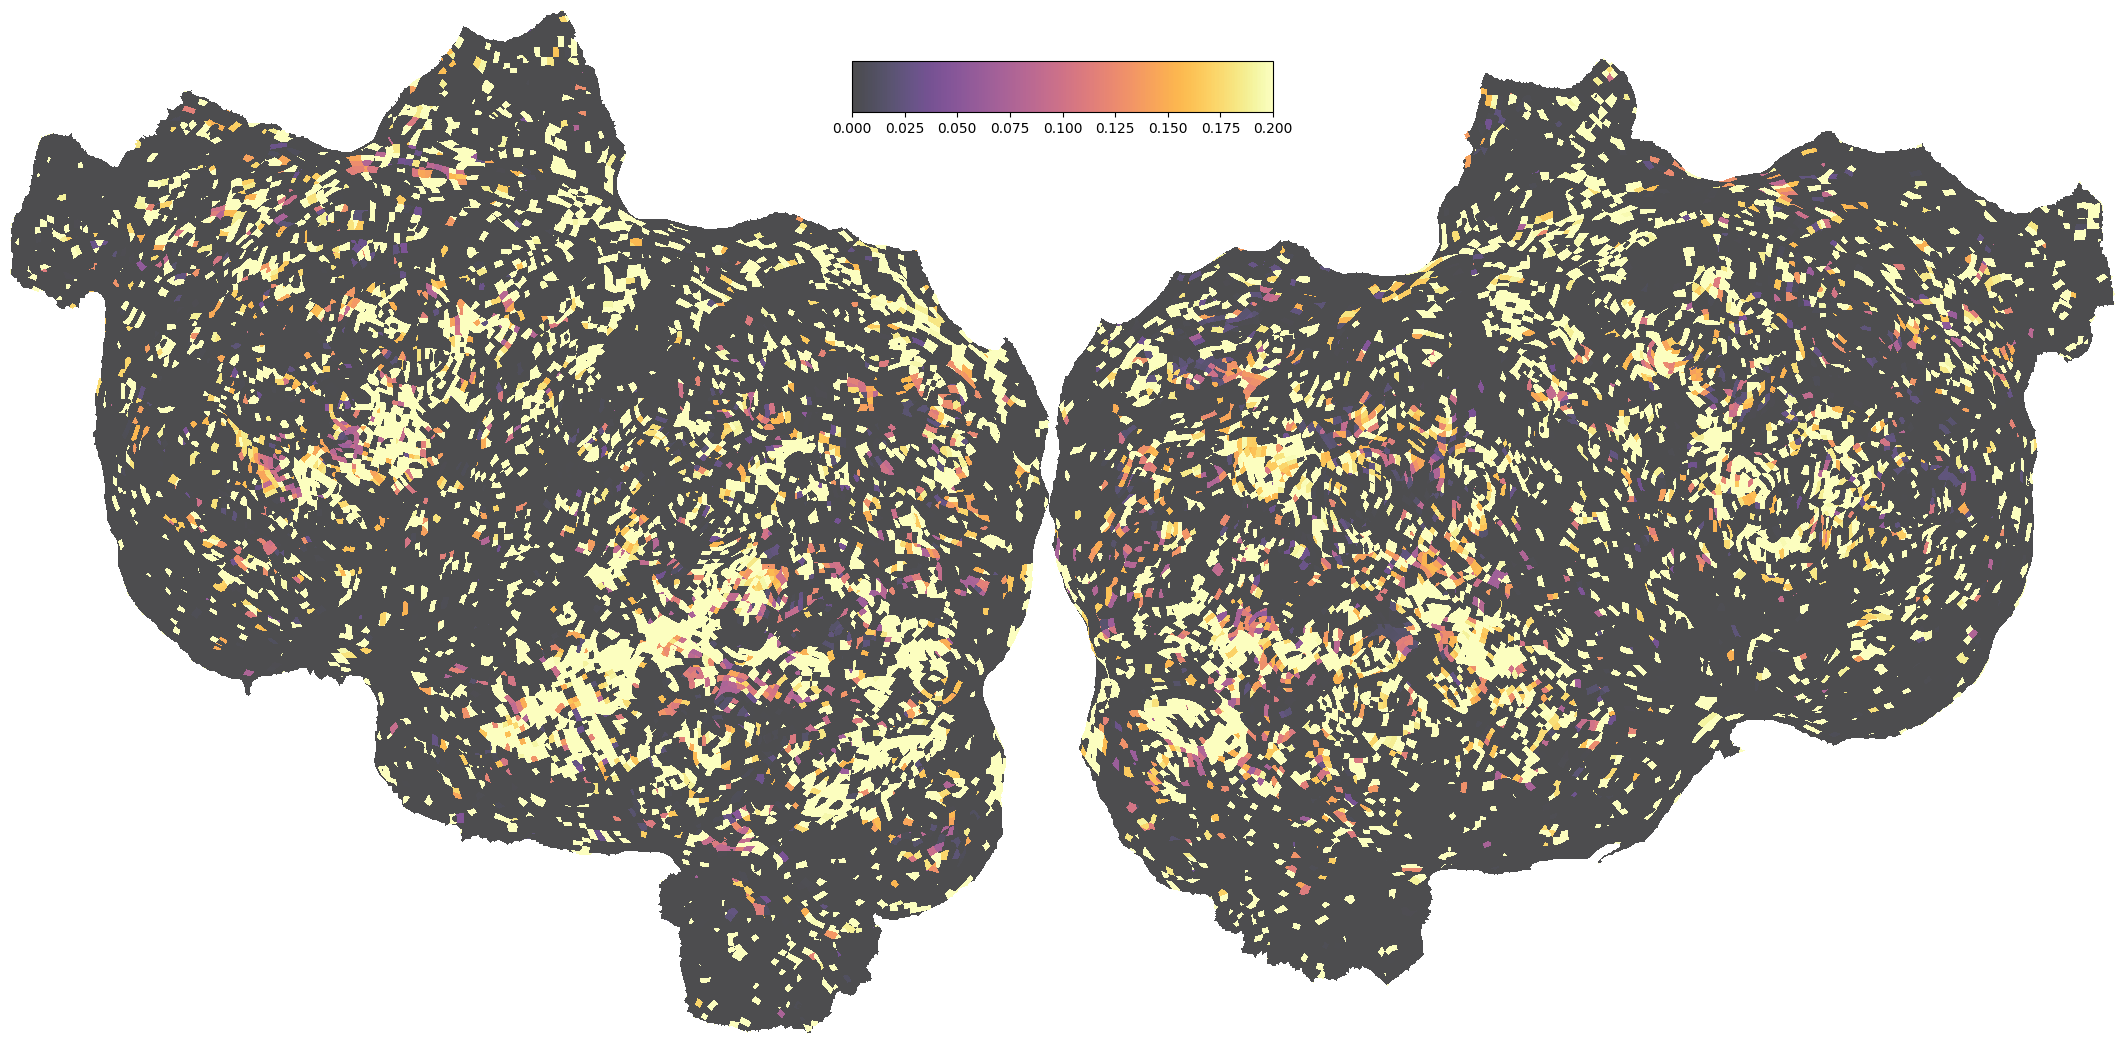

In [24]:
trainer.plot(trainer_config=trainer_config, feature_index=-1, is_corr=True, is_train=True)

In [22]:
del trainer

In [24]:
trainer_config_2 = TrainerConfig(**trainer_config.__dict__)
trainer_config_2.use_fitted_alphas = True
trainer_config_2.use_fitted_deltas = True

In [25]:
trainer = Trainer(sub_config=sub_config, feature_config=feature_config)
trainer.refit_and_evaluate(trainer_config=trainer_config_2)

/home/ra/miniconda3/envs/vem/lib/python3.11/site-packages/himalaya/kernel_ridge/_solvers.py:402: RuntimeWarning: invalid value encountered in divide
  relative_update = backend.abs(update / dual_weights[:, ~converged])


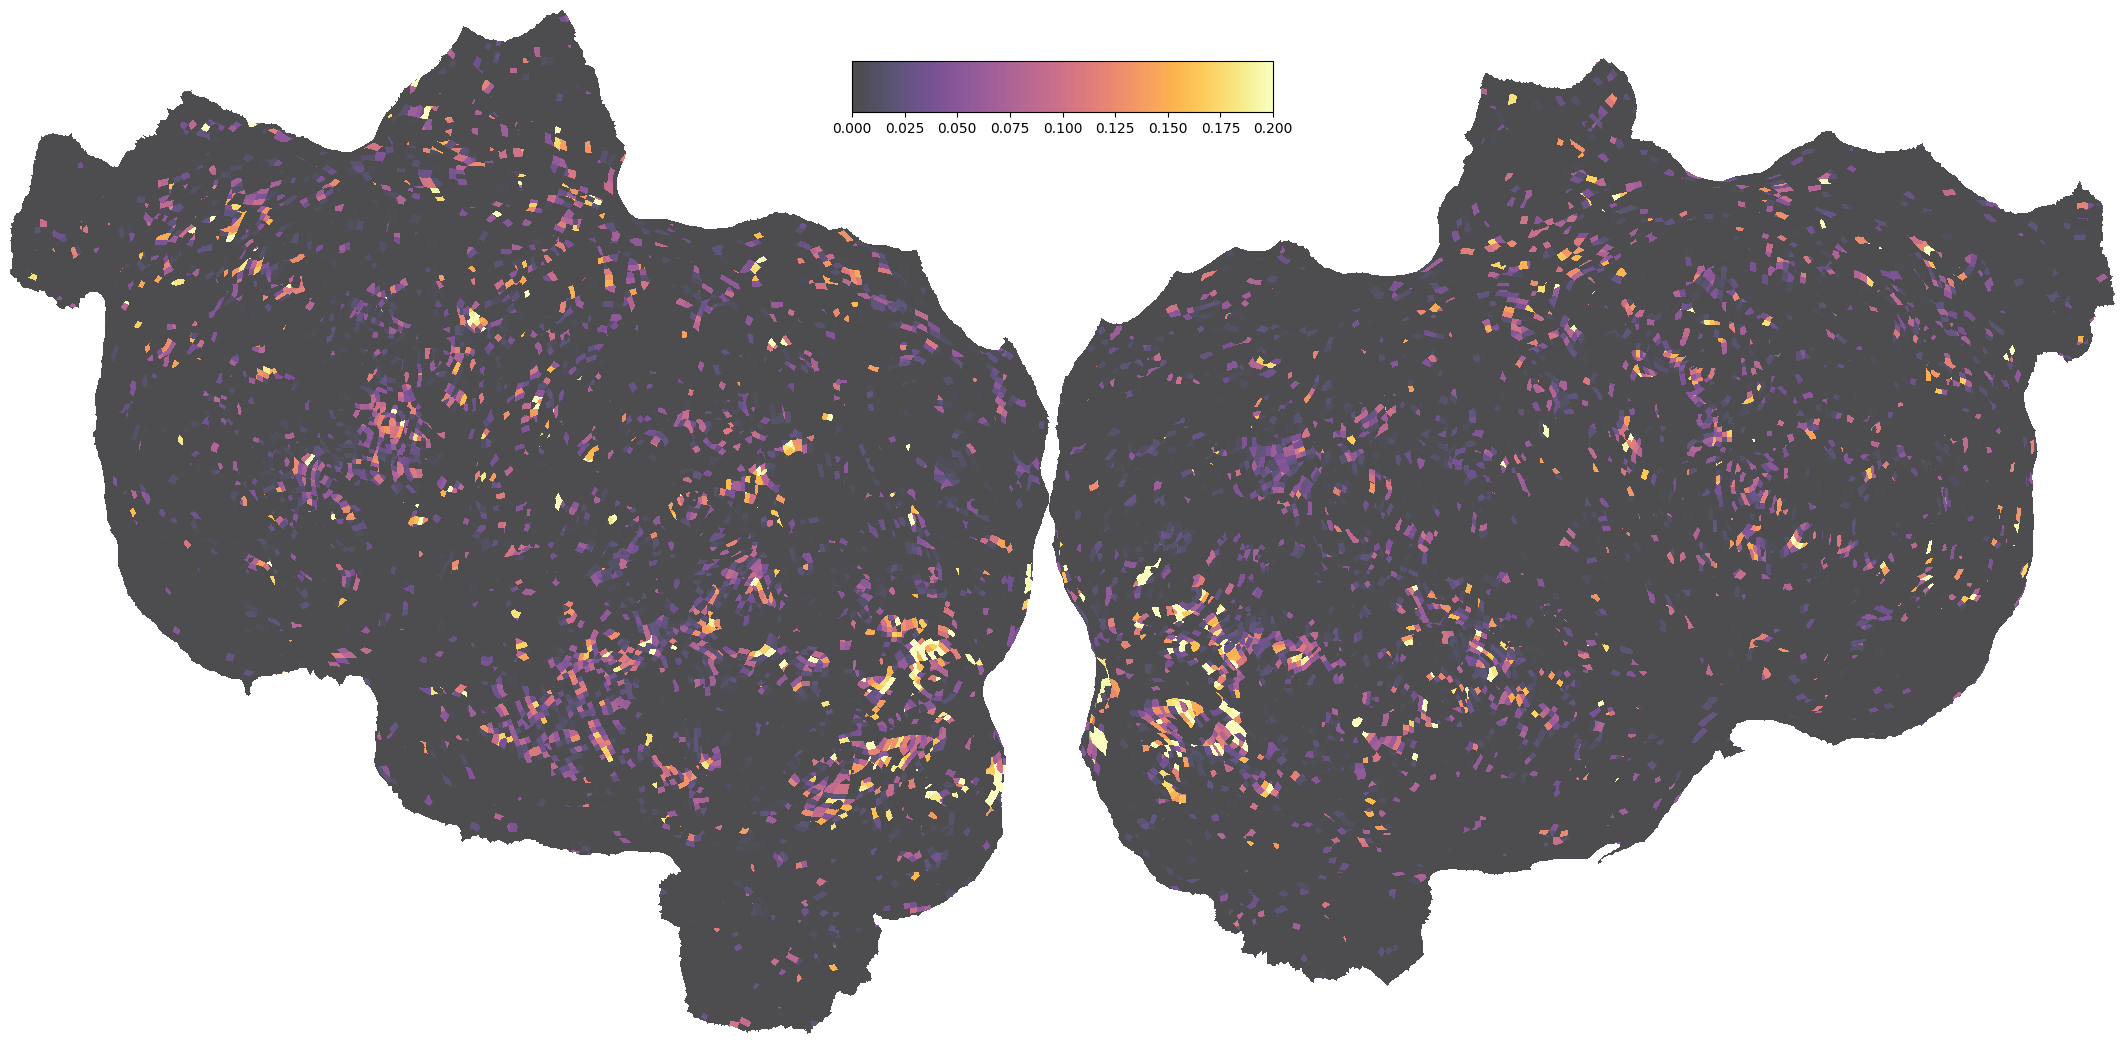

In [29]:
trainer.plot(trainer_config=trainer_config, feature_index=-1, is_corr=True, is_train=False)

In [ ]:
# delete trainer object
del trainer

In [ ]:
trainer = Trainer(sub_config=sub_config)
trainer.load_model(trainer_config=trainer_config)

In [ ]:
trainer.evaluate(trainer_config=trainer_config)

In [ ]:
trainer.plot2d(trainer_config=trainer_config, feature_indices=[0, -1], is_corr=True)

In [ ]:
trainer.plot(trainer_config=trainer_config, feature_index=-1, is_corr=True)

In [ ]:
n_kernels = split_scores_mask.shape[0]
n_voxels = trainer.test_data.shape[1]
split_scores = np.zeros((n_kernels, n_voxels))

In [ ]:
split_scores.shape

In [ ]:
split_scores[:, trainer.mask] = trainer.backend.to_numpy(split_scores_mask)

In [ ]:
trainer.plot(trainer_config=trainer_config, feature_indices=[0, 1])

In [ ]:
trainer.train_data

In [ ]:
trainer.train_feature.shape

In [ ]:
trainer.prepare_test_feature(trainer_config=trainer_config)

In [ ]:
trainer.test_data.shape

In [ ]:
trainer.test_feature.shape

In [ ]:
# now loading
trainer.load_model(trainer_config=trainer_config)

In [ ]:
trainer.evaluate(trainer_config=trainer_config)

In [ ]:
# # save to json
# json_fn = os.path.join('.temp/config', f"sub-{config.sub_id}_task-{config.task}.json")

# with open(json_fn, 'w') as f:
#     json.dump(config.dict(), f, indent=4)

In [ ]:
# # now reload
# with open(json_fn, 'r') as f:
#     config = TrainerConfig(**json.load(f))

In [ ]:
# set_backend(config.backend, on_error="warn")

In [ ]:
# # now load the config files and train
# ## get list of subject config files
# subject_config_files = os.listdir(config_subject_dir)

# ## get list of train config files
# train_json = []
# train_config_dir = os.listdir(config_train_dir)
# for t in train_config_dir:
#     subdir = os.path.join(config_train_dir, t)
#     if os.path.isdir(subdir):
#         # check if there is a json file
#         json_files = os.listdir(subdir)
#         train_json += [os.path.join(t, j) for j in json_files if j.endswith(".json")]

# ## iterate over subject config files
# for sub_files in subject_config_files:
#     # parse json and assing to SubjectConfig
#     with open(os.path.join(config_subject_dir, sub_files)) as f:
#         sub_config = json.load(f)
#     sub_config = SubjectConfig(**sub_config)

#     # iterate over train config files
#     for tj in train_json:
#         # parse json and assing to TrainerConfig
#         with open(os.path.join(config_train_dir, tj)) as f:
#             trainer_config = json.load(f)
#         trainer_config = TrainerConfig(**trainer_config)

#         # train
#         trainer = Trainer(sub_config)
#         trainer.train(trainer_config)

#         # evaluate
#         trainer.evaluate(trainer_config)

#         # # plot
#         # trainer.plot(trainer_config)

#         # # plot 2d
#         # trainer.plot2d(trainer_config)

#         # # save model
#         # trainer.save_model(trainer_config)

#         # # save stat
#         # trainer.save_stat(trainer_config)

#         # # save config

In [ ]:
# prepare data
train_data = load_dict(config.sub_fmri_train_path)
test_data = load_dict(config.sub_fmri_test_path)

In [ ]:
train_data.keys()

In [ ]:
## zscore data
train_data = np.vstack(
    [
        zscore(
            train_data[story][config.sub_trim_start : -config.sub_trim_end, :], axis=0
        )
        for story in list(train_data.keys())
    ]
)
train_data = np.nan_to_num(train_data)

In [ ]:
test_data = np.vstack(
    [
        zscore(
            test_data[story][config.sub_trim_start : -config.sub_trim_end, :], axis=0
        )
        for story in list(test_data.keys())
    ]
)
test_data = np.nan_to_num(test_data)

In [ ]:
# prepare features
## lm-derived feature
lm_features = np.load(config.lm_feature_path, allow_pickle=True)

In [ ]:
lm_train_feature = lm_features["train"].tolist()[config.timescale]
lm_test_feature = lm_features["test"].tolist()[config.timescale]

In [ ]:
# sensory-level features
sensory_level_train_feature = load_dict(config.sensory_feature_train_paths)
sensory_level_test_feature = load_dict(config.sensory_feature_test_paths)

In [ ]:
sensory_level_train_feature_stacked = []
for feature in config.sensory_feature:
    story_stacked = []
    for story in list(sensory_level_train_feature.keys()):
        story_stacked.append(sensory_level_train_feature[story][feature][10:-5])

    sensory_level_train_feature_stacked.append(np.vstack(story_stacked))
sensory_level_train_feature_stacked = np.hstack(sensory_level_train_feature_stacked)
sensory_level_train_feature_stacked = np.nan_to_num(sensory_level_train_feature_stacked)

In [ ]:
sensory_level_test_feature_stacked = []
for feature in config.sensory_feature:
    story_stacked = []
    for story in list(sensory_level_test_feature.keys()):
        story_stacked.append(sensory_level_test_feature[story][feature][10:-5])

    sensory_level_test_feature_stacked.append(np.vstack(story_stacked))
sensory_level_test_feature_stacked = np.hstack(sensory_level_test_feature_stacked)
sensory_level_test_feature_stacked = np.nan_to_num(sensory_level_test_feature_stacked)

In [ ]:
sensory_level_train_feature_stacked.shape

In [ ]:
lm_train_feature.shape

In [ ]:
# TODO: join them. For now, just use LM features
train_feature = np.hstack([lm_train_feature, sensory_level_train_feature_stacked])
# test_feature = lm_test_feature

## make delayed features
delays = np.arange(1, config.feature_delay + 1)

## make delayed features
train_feature = make_delayed(train_feature, delays)
# test_feature = make_delayed(test_feature, delays)

## remove nan
train_feature = np.nan_to_num(train_feature)
# test_feature = np.nan_to_num(test_feature)

In [ ]:
## assert same number of features and timepoints
assert train_data.shape[0] == train_feature.shape[0]
# assert test_data.shape[0] == test_feature.shape[0]

In [ ]:
# now get to the training
## casting
train_feature = train_feature.astype(np.float32)
# test_feature = test_feature.astype(np.float32)

train_data = train_data.astype(np.float32)
# test_data = test_data.astype(np.float32)

In [ ]:
kfold = KFold(n_splits=config.kfolds, shuffle=True, random_state=0)

alphas = np.logspace(config.alpha_min, config.alpha_max, config.alpha_num)

start = time.time()

model = RidgeCV(alphas=alphas, cv=kfold.split(train_data))

model.fit(train_feature, train_data)

print(f"Training took {time.time() - start} seconds")

In [ ]:
best_alpha = model.best_alphas_

# create ridge model with best alpha
model = Ridge(alpha=best_alpha, fit_intercept=False)
model.fit(train_feature, train_data)

In [ ]:

#def train(config: TrainerConfig):
  
    set_backend(config.backend, on_error="warn")

    # prepare data
    train_data = load_dict(config.sub_fmri_train_path)
    test_data = load_dict(config.sub_fmri_test_path)

    ## zscore data
    train_data = np.vstack(
        [
            zscore(train_data[story][config.sub_trim_start:-config.sub_trim_end, :], axis=0)
            for story in train_stories
        ]
    )
    train_data = np.nan_to_num(train_data)
    
    test_data = np.vstack(
        [
            zscore(test_data[story][config.sub_trim_start:-config.sub_trim_end, :], axis=0)
            for story in test_stories
        ]
    )
    test_data = np.nan_to_num(test_data)
        
    # prepare features
    lm_features = np.load(config.lm_feature_path, allow_pickle=True)

    lm_train_feature = lm_features['train'].to_list()
    lm_test_feature = lm_features['test'].to_list()

    ## check if sensory features are available
    if config.sensory_feature_path is not None:
        sensory_features = np.load(config.sensory_feature_path, allow_pickle=True)

        sensory_train_feature = sensory_features['train'].to_list()
        sensory_test_feature = sensory_features['test'].to_list()

    else:
        sensory_train_feature = None
        sensory_test_feature = None
    
    # TODO: join them. For now, just use LM features
    train_feature = lm_train_feature
    test_feature = lm_test_feature

    ## make delayed features
    delays = np.arange(1, config.delays+1)

    ## make delayed features
    train_feature = make_delayed(train_feature, delays)
    test_feature = make_delayed(test_feature, delays)

    ## remove nan
    train_feature = np.nan_to_num(train_feature)
    test_feature = np.nan_to_num(test_feature)

    ## assert same number of features and timepoints
    assert train_data.shape[0] == train_feature.shape[0]
    assert test_data.shape[0] == test_feature.shape[0]

    # now get to the training
    ## casting 
    train_feature = train_feature.astype(np.float32)
    test_feature = test_feature.astype(np.float32)

    training_data = training_data.astype(np.float32)
    test_data = test_data.astype(np.float32)

    ## Ridge regression
    kfold = KFold(n_splits=config.kfolds, shuffle=True, random_state=0)

    alphas = np.logspace(config.alpha_min, config.alpha_max, config.alpha_num)

    start = time.time()

    model = RidgeCV(
        alphas=alphas, cv=kfold.split(training_data)
    )

    model.fit(train_feature, training_data)

    print(f"Training took {time.time() - start} seconds")
        
    best_alpha = model.best_alphas_

    # create ridge model with best alpha
    model = Ridge(alpha=best_alpha, fit_intercept=False)
    model.fit(train_feature, train_data)

    # evaluate on test data
    test_score = model.score(test_feature, test_data)
    print(f"Test score: {test_score}")

    # save weights if path is available
    if os.path.exists(config.weights_save_path) == True:
        print("not saving. path already exists")
    else:    
        np.savez(config.weights_save_path, model.coef_.astype(np.float16))

    if os.path.exists(config.hyperparams_save_path) == True:
        print("not saving hyperparamters file. Path already exists")
    else:
       np.savez(config.hyperparams_save_path, best_alpha.astype(np.float16))